# Solución al problema del costo de un seguro

Primeramente se realizará un preprocesamiento de la información, es decir, se realizará una lectura del archivo .csv y lso datos se guardarán en forma de un arreglo para su posterior uso.

In [1]:
#Importación de librerías que usaremos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Adquisición de datos del dataset
path = "dataset/"
file = "insurance.csv"
insurance_file = pd.read_csv(path + file)
print(insurance_file)
insurance_file.columns

      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]


Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

De la lectura e impresión de los datos del archivo *csv* es posible notar que cuenta con 7 columnas: 
- Age
- Sex
- bmi
- Children
- Smoker
- Region
- Charges

Los datos que se usarán crudos son las columnas 'Age', 'bmi', 'Children' y 'Charges', mientras que las columnas 'Sex', 'Smoker' y 'Region' serán preprocesados.

In [2]:
#Preprocesamiento de datos
insurance_file["sex"] = [(1.0, 2.0)["female"==s] for s in insurance_file["sex"]]
insurance_file["smoker"] = [(1.0, 2.0)["yes"==s] for s in insurance_file["smoker"]]
insurance_file["region"] = [(s, 1.0)["northeast"==s] for s in insurance_file["region"]]
insurance_file["region"] = [(s, 2.0)["northwest"==s] for s in insurance_file["region"]]
insurance_file["region"] = [(s, 3.0)["southeast"==s] for s in insurance_file["region"]]
insurance_file["region"] = [(s, 4.0)["southwest"==s] for s in insurance_file["region"]]

print(insurance_file["region"])

0       4.0
1       3.0
2       3.0
3       2.0
4       2.0
       ... 
1333    2.0
1334    1.0
1335    3.0
1336    4.0
1337    2.0
Name: region, Length: 1338, dtype: float64


Seguidamente mostraremos algunas gráficas entre las variables del problema y el mapa de calor mediante la librería *Seaborn*

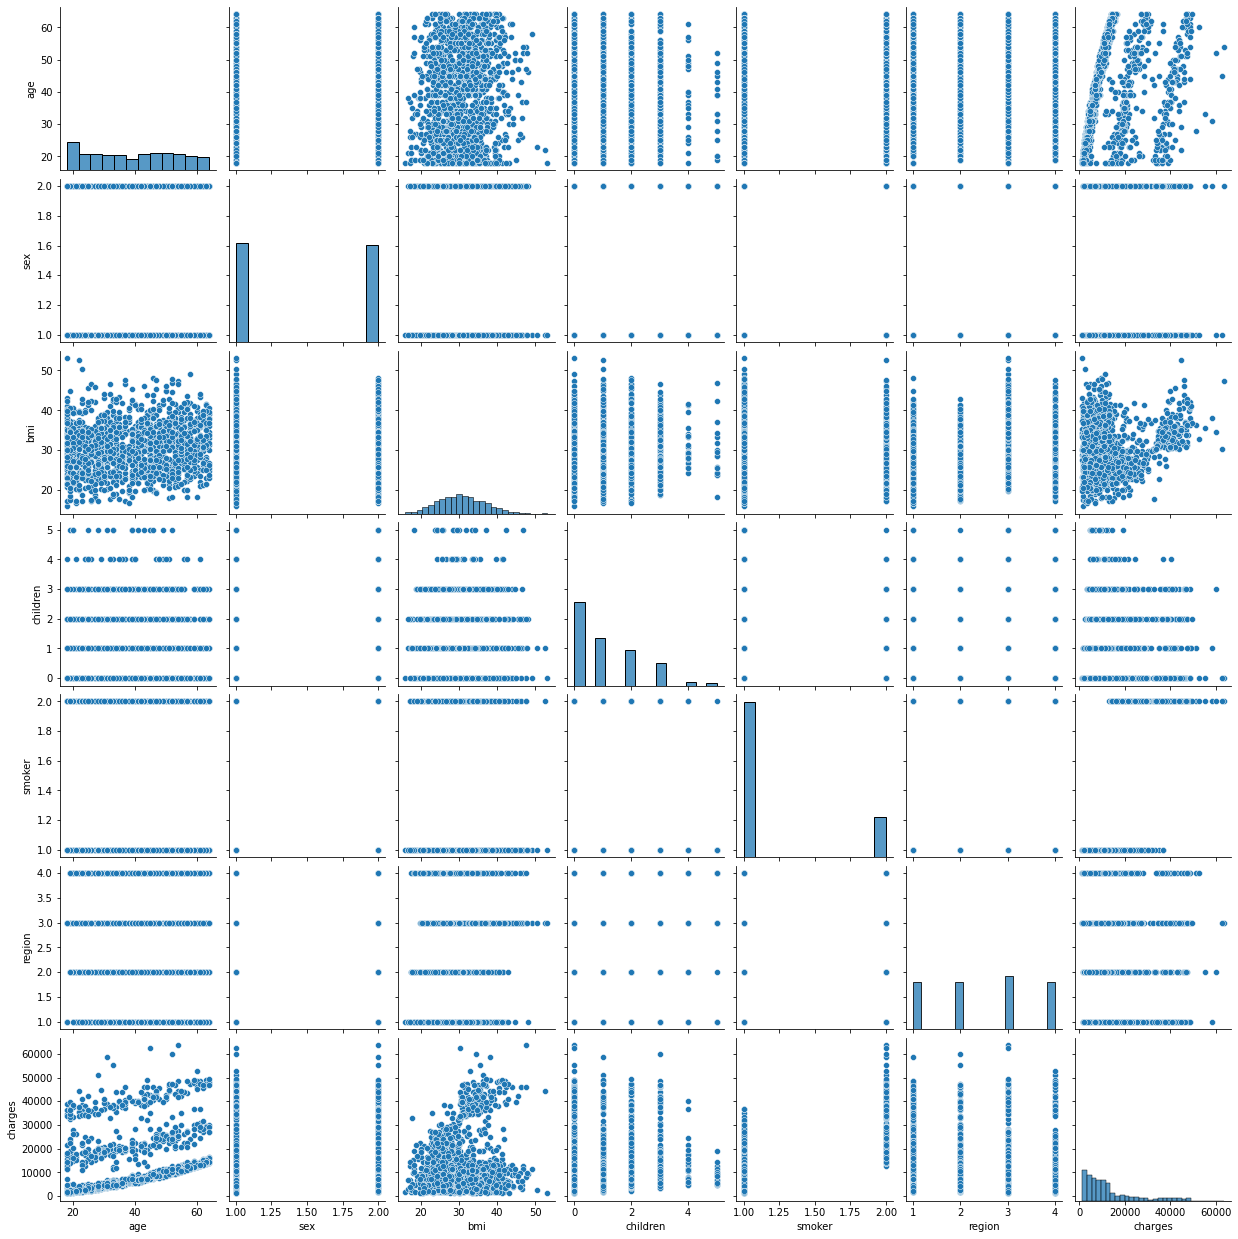

In [3]:
sns.pairplot(insurance_file)
plt.show()

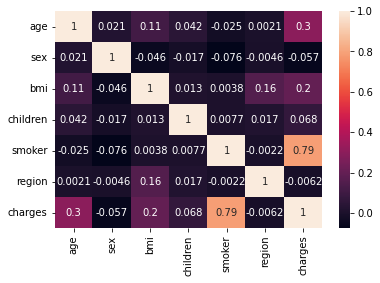

In [4]:
sns.heatmap(insurance_file.corr(), annot=True)
plt.show()

Para acabar con la parte de adquisición y preprocesamiento de datos armaremos los vectores que se usarán en los modelos

In [5]:
#Seleccionamos los conjuntos de datos
x = np.array(insurance_file[['age', 'sex', 'bmi', 'children', 'smoker', 'region']], dtype=float)
y = np.array(insurance_file[['charges']], dtype=float)

#Dividimos los datos en conjuntos de entrenamiento y prueba
seed = 97
test = 0.20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test, random_state=seed)

## Ecuación Normal
<center> $W = (X^TX)^{-1}X^TY$

In [6]:
#Entrenando
w = np.linalg.inv(x_train.T @ x_train) @ x_train.T @ y_train

print(f"Los pesos hallados son:\n {w}")

Los pesos hallados son:
 [[  166.5879039 ]
 [-4215.73310794]
 [ -180.90424787]
 [ -222.23725778]
 [18420.67213969]
 [-1093.61790383]]


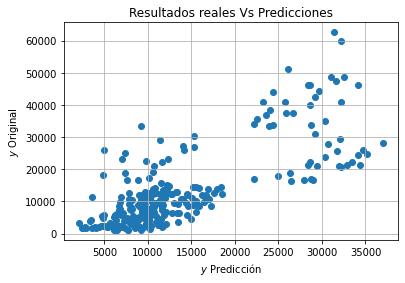

In [7]:
y_pred = x_test @ w

plt.scatter(y_pred, y_test)
plt.ylabel('$y$ Original')
plt.xlabel('$y$ Predicción')
plt.title('Resultados reales Vs Predicciones')
plt.grid(True)
plt.show()

## Batch Gradient Descent

El algoritmo del gradient descent sigue la siguiente ecuación:

$$\theta_j = \theta_j - \eta \nabla_{\theta}J(\theta, x, y)$$

In [8]:
lr = 0.001
epochs = 20000

theta = np.random.rand(6, 1) #Realizamos una inicialización inicial aleatoria
j = np.zeros(epochs) 
m = np.size(x_train)

#Escalamiento de datos
scaler01 = pp.MinMaxScaler() #Normalizacipón
scaler02 = pp.StandardScaler() #Estandarización

x_train_scaled = scaler02.fit_transform(x_train)
y_train_scaled = scaler02.fit_transform(y_train)

for i in range(epochs):
    j[i] = (2/m) * ((x_train_scaled@theta - y_train_scaled)**2).sum()   
    grad = 1/m * x_train_scaled.T.dot(x_train_scaled.dot(theta) - y_train_scaled)
    theta = theta - lr * grad
    

print(f"Los pesos hallados son: {theta}")

Los pesos hallados son: [[ 0.31064023]
 [ 0.02250055]
 [ 0.16086199]
 [ 0.04726187]
 [ 0.80423502]
 [-0.00737061]]


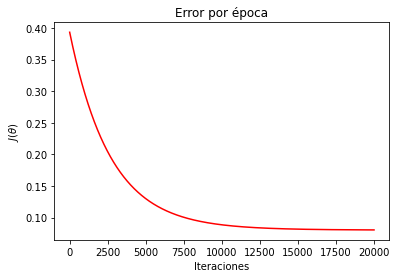

In [9]:
plt.plot(np.arange(epochs), j, 'r')
plt.xlabel('Iteraciones')
plt.ylabel(r'$J(\theta)$')
plt.title('Error por época')
plt.show()

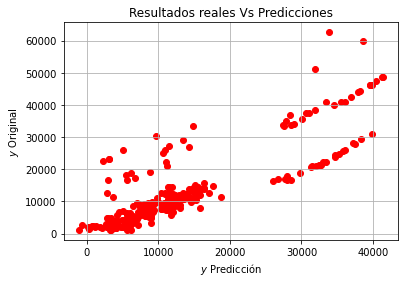

In [10]:
x_test_scaled = scaler02.fit_transform(x_test)
y_test_scaled = scaler02.fit_transform(y_test)

y2_pred = x_test_scaled @ theta
#y2_pred = scaler01.inverse_transform(y2_pred) #Normalización
y2_pred = scaler02.inverse_transform(y2_pred) #Estandarización

plt.scatter(y2_pred, y_test, facecolor='r')
plt.ylabel('$y$ Original')
plt.xlabel('$y$ Predicción')
plt.title('Resultados reales Vs Predicciones')
plt.grid(True)
plt.show()

## Mini batch gradient descent

In [11]:
def mini(x, y, batch_size):
    mini_batches = []
    
    data = np.hstack((x, y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    i = 0
  
    for i in range(n_minibatches + 1):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
        
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    return mini_batches

epochs_mini = 10
lr_mini = 0.001
batch_size = 25

theta_mini = np.random.randn(6, 1)
j_mini = []

for e in range(epochs_mini):
    
    mini_batches = mini(x_train_scaled, y_train_scaled, batch_size)
    
    for mini in mini_batches:
        x_mini, y_mini = mini
        grad_mini = 2*x_mini.T.dot(x_mini.dot(theta_mini)-y_mini)
        theta_mini = theta_mini - lr_mini * grad_mini
        j_mini.append((2/m) * ((x_test_scaled@theta_mini - y_test_scaled)**2).sum())
        

print(theta_mini)


[[ 0.30623329]
 [ 0.00396924]
 [ 0.15986563]
 [ 0.04901765]
 [ 0.80515434]
 [-0.03570082]]


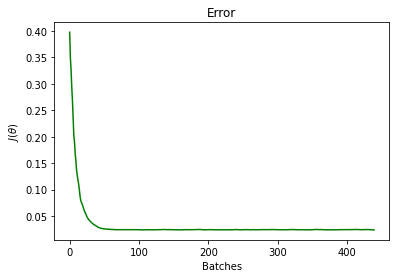

In [20]:
plt.plot(j_mini, 'g')
plt.xlabel('Batches')
plt.ylabel(r'$J(\theta)$')
plt.title('Error')
plt.show()

Para hacer una inferencia es necesario realizar una "Antitransformación" de los datos

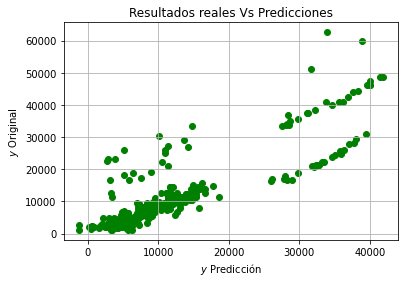

In [13]:
y3_pred = x_test_scaled @ theta_mini
#y3_pred = scaler01.inverse_transform(y3_pred) #Normalización
y3_pred = scaler02.inverse_transform(y3_pred) #Estandarización

plt.scatter(y3_pred, y_test, facecolor='g')
plt.ylabel('$y$ Original')
plt.xlabel('$y$ Predicción')
plt.title('Resultados reales Vs Predicciones')
plt.grid(True)
plt.show()

## Stochastic gradient descent

In [14]:
epochs_st = 70
lr_st = 0.001

theta_st = np.random.randn(6, 1)
j_st = np.zeros(epochs_st)

for e in range(epochs_st):
    j_st[e] = (2/m) * ((x_test_scaled@theta_st - y_test_scaled)**2).sum()   
    for i in range(m):
        random_index = np.random.randint(m)
        xi = x_test_scaled[random_index:random_index+1]
        yi = y_test_scaled[random_index:random_index+1]
        grad_st = 2*xi.T.dot(xi.dot(theta_st)-yi)        
        theta_st = theta_st - lr_st*grad_st

print(theta_st)

[[ 0.23115006]
 [-0.05860475]
 [ 0.19485813]
 [ 0.11128383]
 [ 0.7455079 ]
 [-0.03928667]]


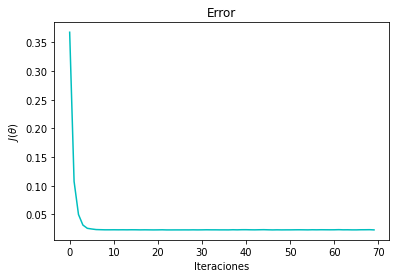

In [15]:
plt.plot(np.arange(epochs_st), j_st, 'c')
plt.xlabel('Iteraciones')
plt.ylabel(r'$J(\theta)$')
plt.title('Error')
plt.show()

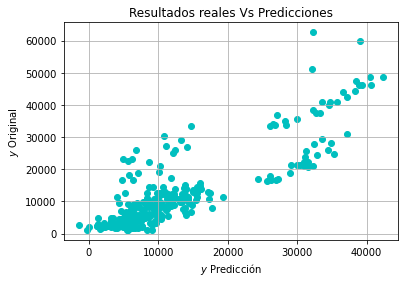

In [16]:
y4_pred = x_test_scaled @ theta_st
#y4_pred = scaler01.inverse_transform(y4_pred) #Normalización
y4_pred = scaler02.inverse_transform(y4_pred) #Estandarización

plt.scatter(y4_pred, y_test, facecolor='c')
plt.ylabel('$y$ Original')
plt.xlabel('$y$ Predicción')
plt.title('Resultados reales Vs Predicciones')
plt.grid(True)
plt.show()

## Inferencia

In [19]:
#Parámetros

idx = 1
y_real = y_test[idx]

#Eq. Normal
y1_inf = x_test[idx] @ w
e1 = abs(y1_inf[0]-y_real)/y_real * 100

print('Inferencia usando la Ecuación Normal\n')
print(f"La puntuación estimada es: {y1_inf[0]}")
print(f"La puntuación real es: {y_real[0]}")
print(f'Error porcentual: {e1[0]}%\n')

# Batch Gradient Descent
y2_inf = y2_pred[idx]
e2 = abs(y2_inf-y_real)/y_real * 100

print('Inferencia usando el Batch Gradient Descent \n')
print(f"La puntuación estimada es: {y2_inf[0]}")
print(f"La puntuación real es: {y_real[0]}")
print(f'Error porcentual: {e2[0]}%\n')

# Mini-Batch Gradient Descent
y3_inf = y3_pred[idx]
e3 = abs(y3_inf-y_real)/y_real * 100

print('Inferencia usando el Mini-Batch Gradient Descent \n')
print(f"La puntuación estimada es: {y3_inf[0]}")
print(f"La puntuación real es: {y_real[0]}")
print(f'Error porcentual: {e3[0]}%\n')

# Stochastic Gradient Descent
y4_inf = y4_pred[idx]
e4 = abs(y4_inf-y_real)/y_real * 100

print('Inferencia usando el Stochastic Gradient Descent \n')
print(f"La puntuación estimada es: {y4_inf[0]}")
print(f"La puntuación real es: {y_real[0]}")
print(f'Error porcentual: {e4[0]}%\n')


Inferencia usando la Ecuación Normal

La puntuación estimada es: 10537.068624285062
La puntuación real es: 13887.9685
Error porcentual: 24.12807802462209%

Inferencia usando el Batch Gradient Descent 

La puntuación estimada es: 16430.518557575906
La puntuación real es: 13887.9685
Error porcentual: 18.30757362083522%

Inferencia usando el Mini-Batch Gradient Descent 

La puntuación estimada es: 15936.17225770816
La puntuación real es: 13887.9685
Error porcentual: 14.748044378903646%

Inferencia usando el Stochastic Gradient Descent 

La puntuación estimada es: 13931.95085849106
La puntuación real es: 13887.9685
Error porcentual: 0.3166939678114847%

